**Copyright © 2025 Raphael Senn. Licensed under the MIT License.**

**Author:** Raphael Senn (<raphaelsenn@gmx.de>)

# Generative Adversarial Networks (Goodfellow et al., 2014)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import FashionMNIST

from src.gan_fc import (
    Generator,
    Discriminator,
)

from src.objective import (
    GeneratorLoss,
    DiscriminatorLoss
)

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

#### Exploring the training dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                      # pixel transform: img.range[0, 255] -> img.range[0, 1]
    transforms.Lambda(lambda x: x.view(-1))     # shape transfrom: img.shape[1, 28, 28] -> img.shape[1, 784]
])

dataset = FashionMNIST(root='./FASHION_MNIST/', train=True, download=True, transform=transform)

#### Visualizing the Training Data

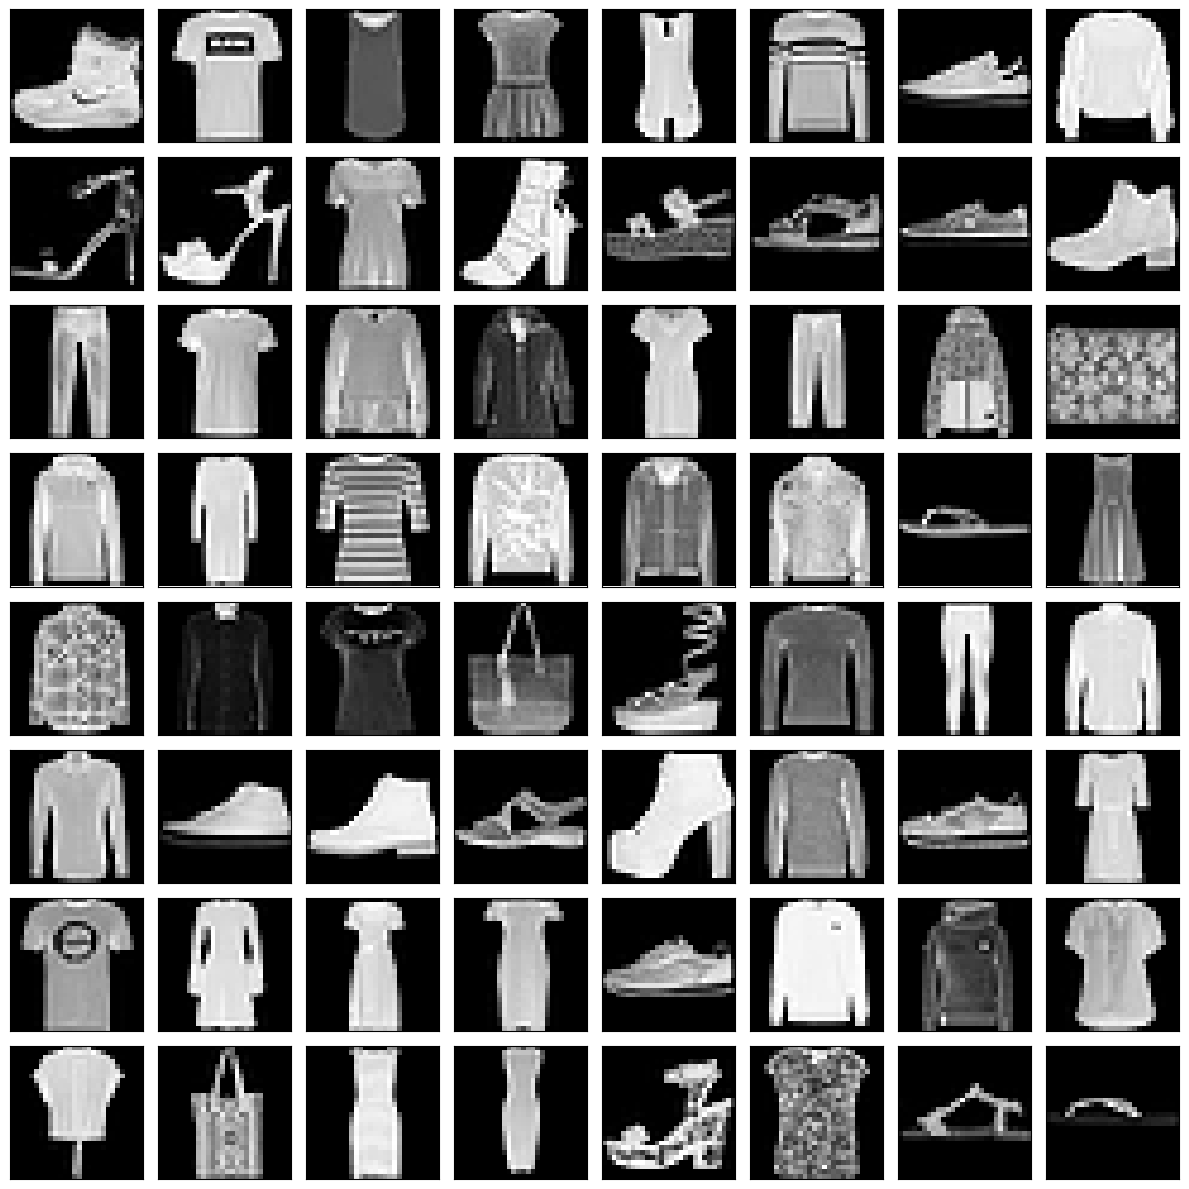

In [4]:
FIGSIZE = (12, 12)
IMAGE_SHAPE = (28, 28)
N_ROWS, N_COLS = 8, 8

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()

for i in range(N_ROWS * N_COLS):
    img, _ = dataset[i]
    img = img.reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([]),
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training Setup

In [5]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(SEED)
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): 
    device = torch.device('mps')
else: 
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: mps


In [6]:
# Create generator and discriminator
DIM_NOISE = 100
generator = Generator(DIM_NOISE).to(device)
discriminator = Discriminator().to(device)

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
SHUFFLE = True

LR_G = 0.002
LR_D = 0.002

BETAS_G = (0.5, 0.99)
BETAS_D = (0.5, 0.99)

# Create the optimizer and the loss
criterion_g = GeneratorLoss()
optimizer_g = torch.optim.Adam(params=generator.parameters(), lr=LR_G, betas=BETAS_G)

criterion_d = DiscriminatorLoss()
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=LR_D, betas=BETAS_D)

# Load the dataset
dataloader = DataLoader(dataset, BATCH_SIZE, SHUFFLE)

In [7]:
num_params_g = sum(p.numel() for p in generator.parameters())
num_params_d = sum(p.numel() for p in discriminator.parameters())
print(f'Generator has: {num_params_g} learnable parameters')
print(f'Discrimintor has: {num_params_d} learnable parameters')

Generator has: 2503984 learnable parameters
Discrimintor has: 1231441 learnable parameters


In [8]:
# Print settings
VERBOSE = True

# Plot settings
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1
PLOTTING = True
SAVE_LOC = './fashion_mnist_fake'

if PLOTTING:
    if not os.path.exists(SAVE_LOC):
        os.mkdir(SAVE_LOC)

#### Start Training

In [9]:
losses_d, losses_g = [], []
N_samples = len(dataset)
for epoch in range(EPOCHS):

    total_loss_g, total_loss_d = 0.0, 0.0
    for x, _ in dataloader:
        # x is sampled from data generating distribution x ~ p_data
        x = x.to(device)

        # z is sampled from noise prior z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1

        with torch.no_grad():
            G_z = generator(z)

        D_x = discriminator(x)
        D_G_z = discriminator(G_z)

        # update descriminator by ascending its stochastic gradient
        optimizer_d.zero_grad()
        loss_d = criterion_d(D_x, D_G_z)
        loss_d.backward()
        optimizer_d.step()

        # z is sampled from noise prior
        # z ~ p_noise
        z = torch.rand(size=(x.shape[0], DIM_NOISE), device=device) * 2 - 1
        D_G_z = discriminator(generator(z))

        # update generator by descending its stochastic gradient
        optimizer_g.zero_grad()
        loss_g = criterion_g(D_G_z)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item() * x.shape[0]
        total_loss_g += loss_g.item() * z.shape[0]
    
    losses_d.append(total_loss_d / N_samples)
    losses_g.append(total_loss_g / N_samples)

    if VERBOSE: 
        print(
            f'epoch: {epoch}\t' 
            f'generator loss: {(total_loss_g/N_samples):.4f}\t'
            f'discriminator loss: {(total_loss_d/N_samples):.4f}'
        )

    if PLOTTING:
        G_z = generator(Z)
        fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
        ax = ax.flatten()
        for i in range(N_ROWS * N_COLS):
            img = G_z[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
            ax[i].imshow(img, cmap='gray')
            ax[i].axis('off')
        fig.tight_layout()
        fig.savefig(os.path.join(SAVE_LOC, f'fashion_mnist_{epoch}'))
        plt.close(fig)

epoch: 0	generator loss: 1.5144	discriminator loss: 1.1255
epoch: 1	generator loss: 1.0002	discriminator loss: 1.3084
epoch: 2	generator loss: 0.8986	discriminator loss: 1.3535
epoch: 3	generator loss: 0.8666	discriminator loss: 1.3649
epoch: 4	generator loss: 0.8368	discriminator loss: 1.3775
epoch: 5	generator loss: 0.8399	discriminator loss: 1.3790
epoch: 6	generator loss: 0.8408	discriminator loss: 1.3751
epoch: 7	generator loss: 0.8412	discriminator loss: 1.3768
epoch: 8	generator loss: 0.8366	discriminator loss: 1.3790
epoch: 9	generator loss: 0.8411	discriminator loss: 1.3776
epoch: 10	generator loss: 0.8350	discriminator loss: 1.3794
epoch: 11	generator loss: 0.8396	discriminator loss: 1.3797
epoch: 12	generator loss: 0.8471	discriminator loss: 1.3737
epoch: 13	generator loss: 0.8432	discriminator loss: 1.3797
epoch: 14	generator loss: 0.8503	discriminator loss: 1.3791
epoch: 15	generator loss: 0.8633	discriminator loss: 1.3714
epoch: 16	generator loss: 0.8526	discriminator los

#### GAN Training Losses

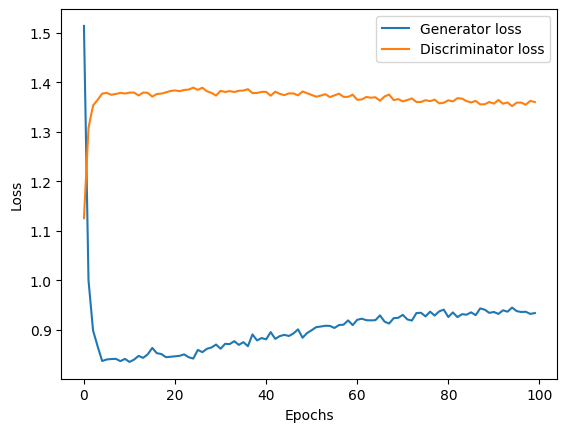

In [10]:
_, ax = plt.subplots()
ax.plot(np.arange(len(losses_g)), losses_g, label='Generator loss')
ax.plot(np.arange(len(losses_d)), losses_d, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

#### Generating Fake Data

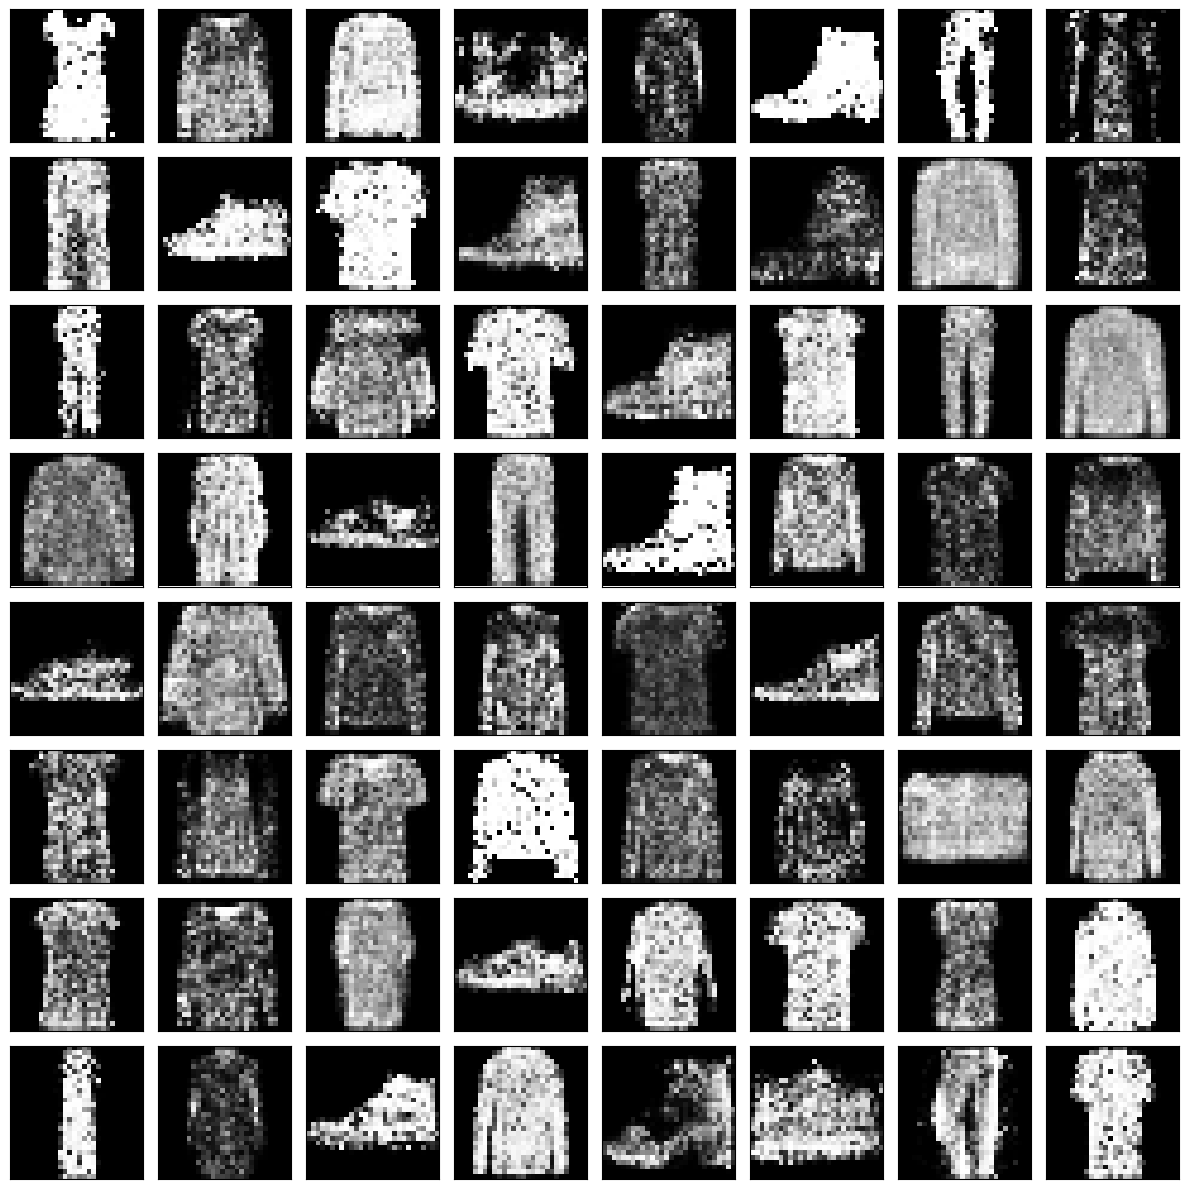

In [11]:
Z = torch.rand(size=(N_ROWS * N_COLS, DIM_NOISE), device=device) * 2 - 1
data_fake = generator(Z)

_, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIGSIZE)
ax = ax.flatten()
for i in range(N_ROWS * N_COLS):
    img = data_fake[i].cpu().detach().numpy().reshape(IMAGE_SHAPE)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_xticks([]),
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()